<img src="https://i.imgur.com/vnejHGh.png" width="800">

<!--- @wandbcode{huggingface_tables} -->


<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/huggingface/Visualize_your_Hugging_Face_data_with_Weights_%26_Biases.ipynb" target="_parent"><img src="https://
colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize your 🤗 Hugging Face data with 🏋‍♀️ Weights & Biases

[Hugging Face](https://huggingface.co/) provides tools to quickly train neural networks for NLP (Natural Language Processing) on any task (classification, translation, question answering, etc) and any dataset with PyTorch and TensorFlow 2.0.

Coupled with [Weights & Biases integration](https://docs.wandb.ai/integrations/huggingface), you can quickly train and monitor models for full traceability and reproducibility without any extra line of code! You just need to install the library, sign in, and your experiments will automatically be logged:

```bash
pip install wandb
wandb login
```

**Note**: To enable logging to W&B, set `report_to` to `wandb` in your `TrainingArguments` or script.

## 🛠️ Installation and set-up

In [ ]:
%%capture
!pip install transformers datasets wandb

In [ ]:
import wandb
wandb.login()

# 🛫 Data and model preparation

### 🏷️ Loading a dataset

We'll download the
[Yahoo! Answers Dataset](https://paperswithcode.com/sota/text-classification-on-yahoo-answers),
which includes questions and answers from the now-defunct
[Yahoo! Answers forum](https://en.wikipedia.org/wiki/Yahoo!_Answers).

In [ ]:
from datasets import load_dataset
dataset = load_dataset("yahoo_answers_topics")
dataset

Data includes question titles, question bodies and best answers (for some questions), and a question topic from one of 10 choices.

In [ ]:
dataset['train'][0]

For our text classification task, we use `question_title` as input and try to predict `topic`.

In [ ]:
label_list = dataset['train'].unique('topic')
label_list.sort()
label_list

In [ ]:
num_labels = len(label_list)
num_labels

The "topic" class needs to be renamed to "labels" for the `Trainer` to find it.

In [ ]:
dataset.rename_column_('topic', 'labels')

For the purpose of this demo, we'll decrease the size of the dataset for faster training.

In [ ]:
dataset['train'] = dataset['train'].select(range(dataset['train'].num_rows // 10))
dataset['test'] = dataset['test'].select(range(dataset['test'].num_rows // 10))

### ⚙️ Tokenizing the dataset

In a typical NLP workflow, we must first tokenize our dataset -- converting the stream of characters in the text into a stream of defined "tokens", which can be anything from a smaller set of characters to words from a vocabulary.

We will use a pretrained model for our , so we inherit its tokenization scheme.
Hugging Face makes this easy with the `AutoTokenizer`:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
sample_input = dataset['train'][0]['question_title']
print(sample_input, "\n", tokenizer(sample_input))

We then map the tokenizer over our dataset:

In [ ]:
dataset = dataset.map(lambda x: tokenizer(x['question_title'], truncation=True), batched=True)

### ✨ Loading a model

In this case, we are loading a pre-trained network to which a custom head has been added for sequence classification.


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)


Let's make a function to return the topic prediction from a sample question.

In [ ]:
import torch

def get_topic(sentence, tokenize=tokenizer, model=model):
    # tokenize the input
    inputs = tokenizer(sentence, return_tensors='pt')
    # ensure model and inputs are on the same device (GPU)
    inputs = {name: tensor.cuda() for name, tensor in inputs.items()}
    model = model.cuda()
    # get prediction - 10 classes "probabilities" (not really true because they still need to be normalized)
    with torch.no_grad():
        predictions = model(**inputs)[0].cpu().numpy()
    # get the top prediction class and convert it to its associated label
    top_prediction = predictions.argmax().item()
    return dataset['train'].features['labels'].int2str(top_prediction)

We can test our prediction pipeline on a sample sentence.

In [ ]:
get_topic('Why is cheese so much better with wine?')

When we ran our model, we got the answer `Politics & Government`,
which doesn't seem quite right for a question about cheese and wine.

That's because the model has not been trained yet so the outputs are still random. But at least we have a working pipeline!

# 📊 Log your data for better visualization


Before we train our model, let's set up some better logging during training.

Without the ability to inspect model behavior, it can be hard to debug or understand models.
So we'll log a table of information about the model's behavior on the validation set --
not just the loss or accuracy, but the inputs and outputs as well.

Our data is already in a pandas `DataFrame`, so there's not much we have to do besides
slightly reformat them
and then use them to define a `ValidationDataLogger` instance.

In [ ]:
from wandb.sdk.integration_utils.data_logging import ValidationDataLogger

In [ ]:
validation_inputs = dataset['test'].remove_columns(['labels', 'attention_mask', 'input_ids'])
validation_targets = [dataset['test'].features['labels'].int2str(x) for x in dataset['test']['labels']]

validation_inputs[0], validation_targets[0]

In [ ]:
validation_logger = ValidationDataLogger(
    inputs = validation_inputs[:],
    targets = validation_targets
)

We can now log our predictions for visualization with `validation_logger.log_predictions(prediction_labels)`.

# 👟 Training the model and logging to W&B

We are now ready to fine-tune the model to solve our task.

The Hugging Face [`Trainer` class](https://huggingface.co/transformers/main_classes/trainer.html)
lets us easily train a model and is very flexible.

**Note:** set `report_to` to `wandb` in `TrainingArguments` to enable logging through W&B.

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    report_to='wandb',                    # enable logging to W&B
    output_dir='topic_classification',    # set output directory
    overwrite_output_dir=True,
    evaluation_strategy='steps',          # check evaluation metrics on a given # of steps
    learning_rate=5e-5,                   # we can customize learning rate
    max_steps=1000,
    logging_steps=100,                    # we will log every 100 steps
    eval_steps=500,                       # we will perform evaluation every 1000 steps
    eval_accumulation_steps=1,            # report evaluation results after each step
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    run_name='my_training_run'            # name of the W&B run
)

In [ ]:
# automatically log model to W&B at the end
%env WANDB_LOG_MODEL=true

For more customization, refer to [`TrainingArguments` documentation](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments).

We can optionally define metrics to calculate in addition to the loss through the `compute_metrics` function.

Several [metrics](https://huggingface.co/metrics) are readily available from the datasets library to monitor model performance.

We'll also use it to log all of our predictions at each evaluation loop,
using the `validation_logger`.

In [ ]:
from datasets import load_metric
import numpy as np

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # convert predictions from class (0, 1, 2…) to label (Health, Science…)
    prediction_labels = [dataset['test'].features['labels'].int2str(x.item())
                         for x in predictions]
    
    # log predictions
    validation_logger.log_predictions(prediction_labels)

    # metrics from the datasets library have a compute method
    return accuracy_metric.compute(predictions=predictions, references=labels)

The `Trainer` handles all the training & evaluation logic.

In [ ]:
trainer = Trainer(
    model=model,                  # model to be trained
    args=args,                    # training args
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,            # for padding batched data
    compute_metrics=compute_metrics # for custom metrics
)

In [ ]:
trainer.train()

We can now easily observe your predictions live in your run dashboard!

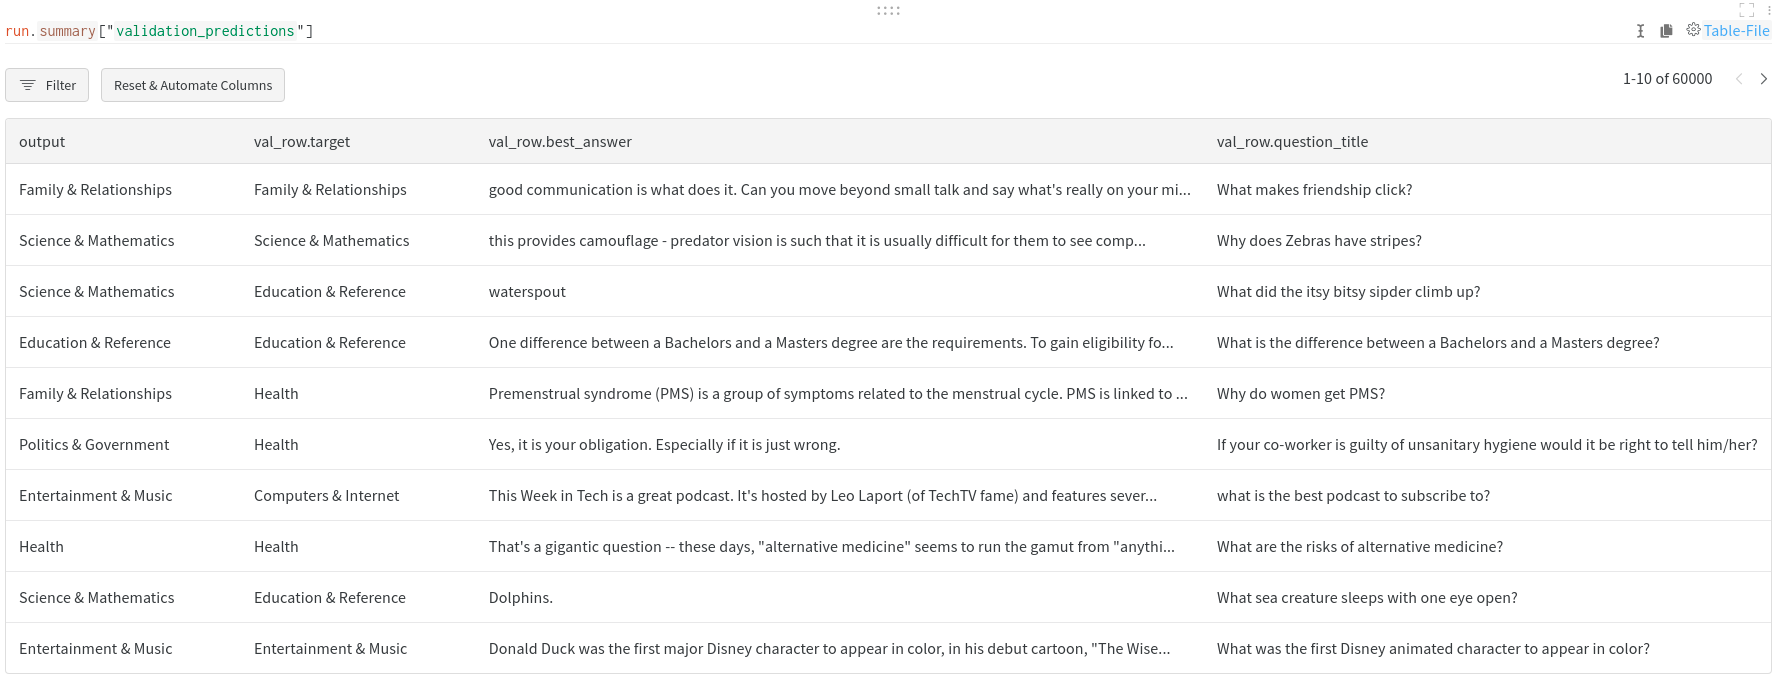

We can monitor losses, metrics, gradients and parameters as the model trains.

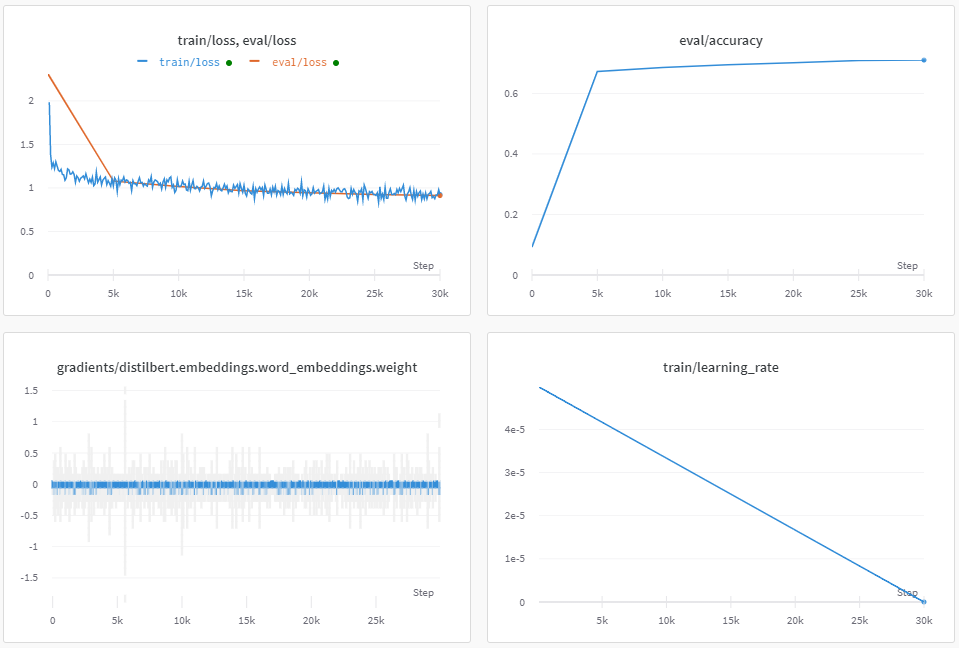

When training is complete, our model is logged and versioned along with its performance as metadata.

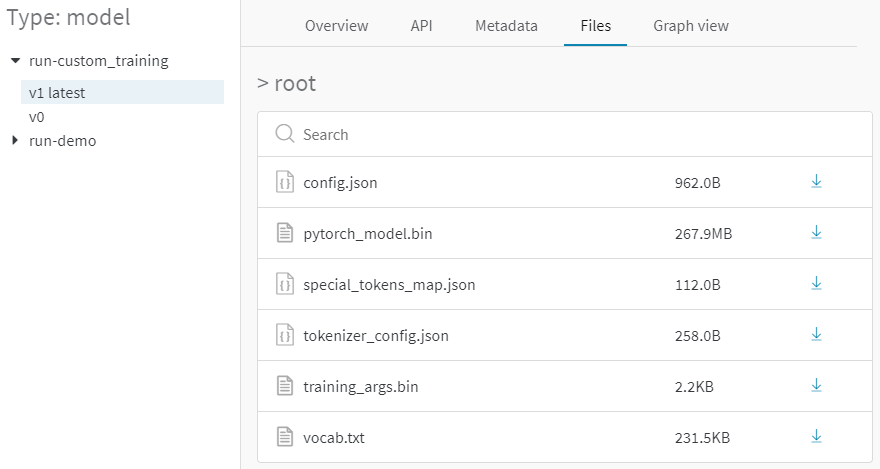

When we want to close our W&B run, we can call `wandb.finish()` (mainly useful in notebooks, called automatically in scripts).

In [ ]:
wandb.finish()